In [1]:
!pip install image-classifiers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 08:22:12.183989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 08:22:12.184096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 08:22:12.321206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [6]:
from classification_models.tfkeras import Classifiers

In [7]:
SeResNet, preprocess_input = Classifiers.get("seresnet101")

In [8]:
base_model = SeResNet(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

190663368/190663368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    47,383,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_33     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,383,216 (180.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 47,383,216 (180.75 MB)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29:12 36s/step - AUC: 0.6667 - Precision: 1.0000 - Recall: 0.3333 - accuracy: 0.5000 - loss: 0.7247

I0000 00:00:1715156589.931916     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715156590.028483     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.7006 - Precision: 0.6193 - Recall: 0.6469 - accuracy: 0.6527 - loss: 0.6762

W0000 00:00:1715156604.006198     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.57292, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 436ms/step - AUC: 0.7007 - Precision: 0.6195 - Recall: 0.6459 - accuracy: 0.6525 - loss: 0.6762 - val_AUC: 0.7289 - val_Precision: 0.8889 - val_Recall: 0.1667 - val_accuracy: 0.5729 - val_loss: 1.0394
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUC: 0.6621 - Precision: 0.6178 - Recall: 0.6341 - accuracy: 0.6357 - loss: 0.6716
Epoch 2: val_accuracy improved from 0.57292 to 0.61806, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - AUC: 0.6630 - Precision: 0.6192 - Recall: 0.6343 - accuracy: 0.6365 - loss: 0.6707 - val_AUC: 0.8839 - val_Precision: 0.5720 - val_Recall: 0.9375 - val_accuracy: 0.6181 - val_loss: 0.9255
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.7781 - Precision: 0.7849 - Recall: 0.7146 - accuracy: 0.7423 - loss: 0.5600
Epoch 3: val_accuracy improved from 0.61806 to 0.62153, saving model to best_model.keras


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy improved from 0.82986 to 0.86111, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - AUC: 0.8309 - Precision: 0.7252 - Recall: 0.7251 - accuracy: 0.7379 - loss: 0.5140 - val_AUC: 0.9014 - val_Precision: 0.9407 - val_Recall: 0.7708 - val_accuracy: 0.8611 - val_loss: 0.3931
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.7866 - Precision: 0.6462 - Recall: 0.6278 - accuracy: 0.6908 - loss: 0.5524
Epoch 7: val_accuracy did not improve from 0.86111
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - AUC: 0.7851 - Precision: 0.6464 - Recall: 0.6268 - accuracy: 0.6903 - loss: 0.5538 - val_AUC: 0.8138 - val_Precision: 0.6545 - val_Recall: 0.8681 - val_accuracy: 0.7049 - val_loss: 0.5576
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.6694 - Precision: 0.6760 - Recall: 0.6472 - accuracy: 0.6814 - loss: 0.6769
Epoch 8: val_accuracy did not improve from 0.86111
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - AUC: 0.6697 - Precision: 0.6753

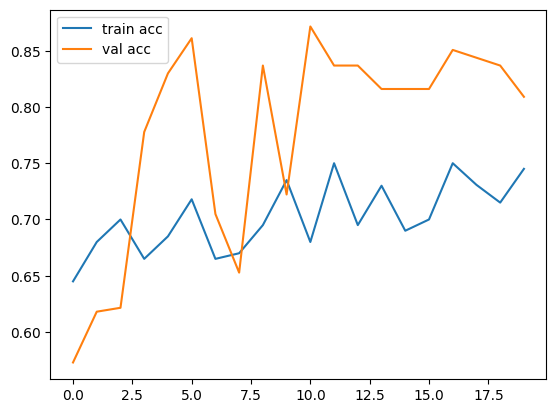

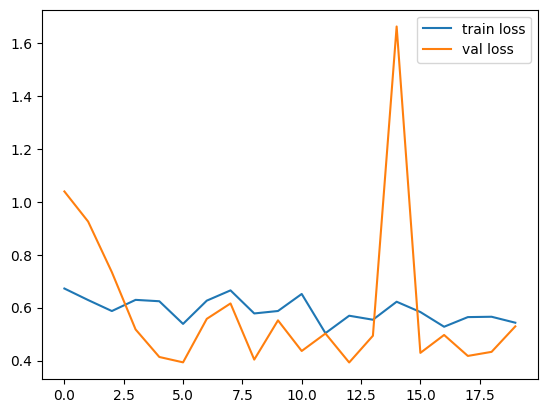

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('SeResNet101-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('SeResNet101-loss.png')
plt.show()

In [12]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - AUC: 0.8679 - Precision: 0.8993 - Recall: 0.6606 - accuracy: 0.7642 - loss: 0.5912


[0.6492776274681091,
 0.7654028534889221,
 0.8528828620910645,
 0.9090909361839294,
 0.6746031641960144]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[[0.25265175]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


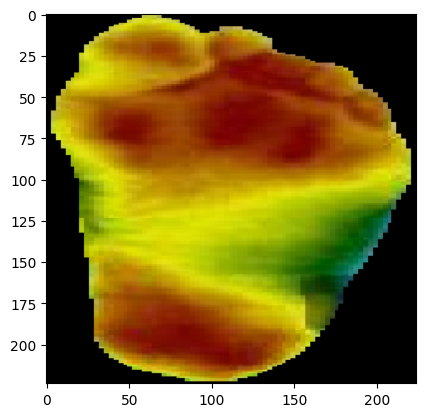

In [13]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.07568888]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


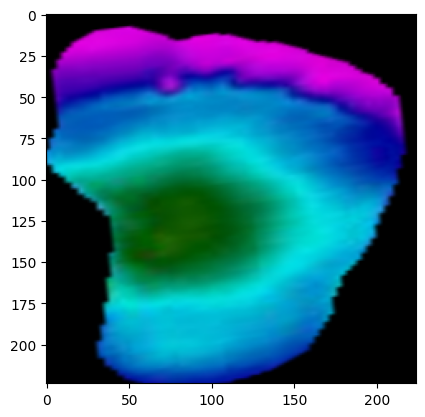

In [14]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))